In [13]:
from Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from BaggingSA import BaggingSA
from typing import Literal, Tuple
from Bagging import predict
import sklearn
from plots_manager import *


In [14]:
df = pd.read_csv('./../res/bagging_sa_params_aggregated.csv')

In [15]:
def get_fadr_fmc_for_min_error(df: pd.DataFrame, dataset: str) -> Tuple[float, float]:
    tmp_df = df[df['dataset'] == dataset]
    X1 = tmp_df['fadr'].values
    X2 = tmp_df['fmc'].values
    Y1 = tmp_df['accFitnessDifferenceMean'].values
    Y2 = tmp_df['correlationMean'].values
    
    error = np.sqrt((1-Y2)**2 + (Y1)**2)
    min_error_index = np.argmin(error)
    fadr = X1[min_error_index]
    fmc = X2[min_error_index]
    return fadr, fmc
    
    
    


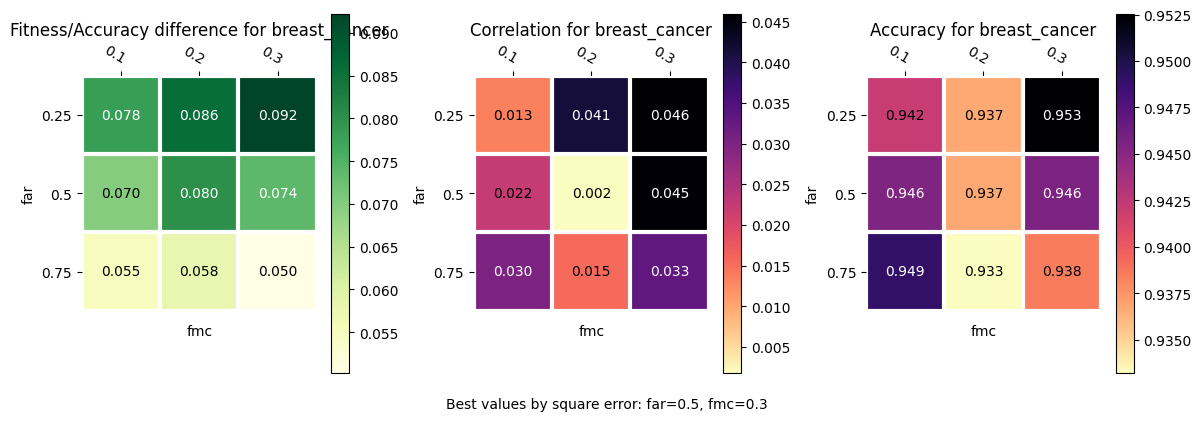

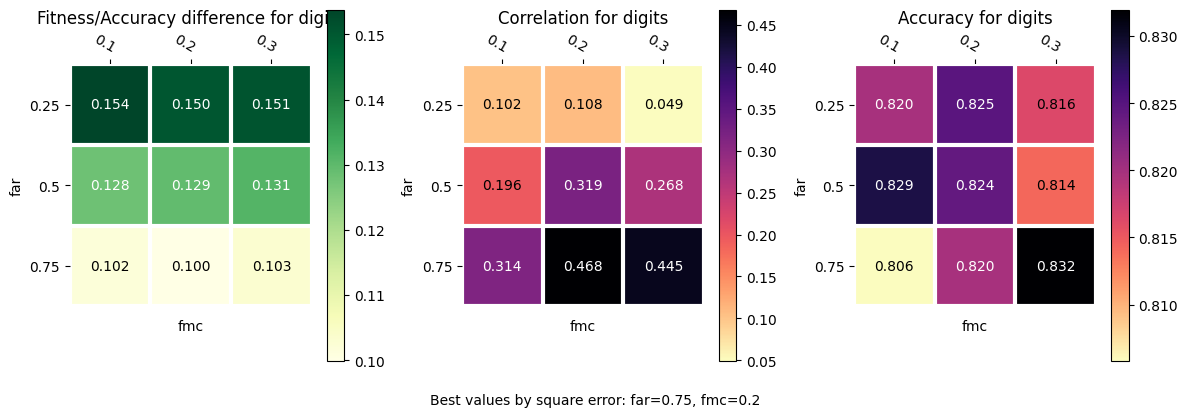

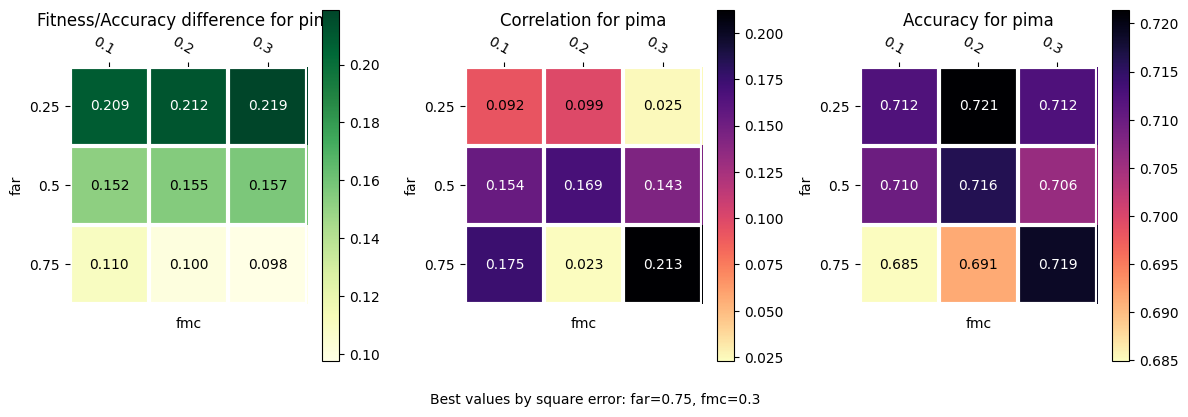

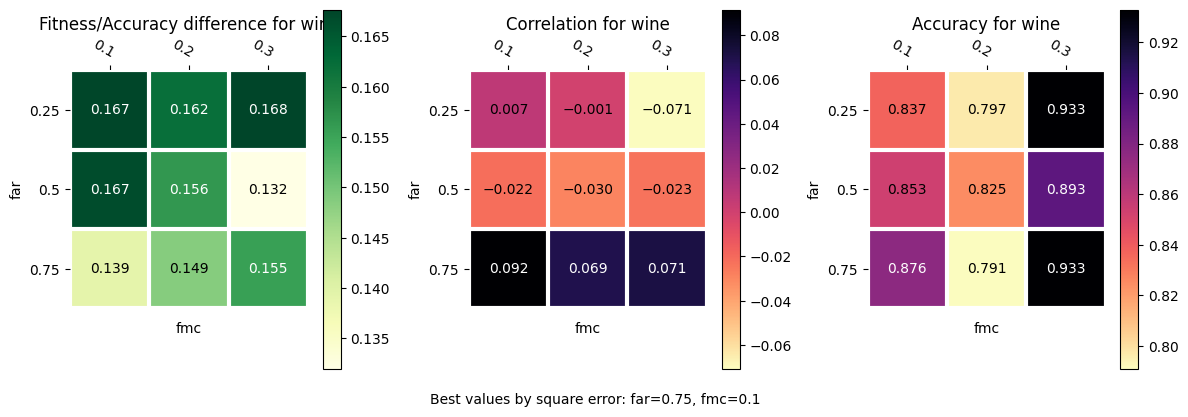

In [17]:
def create_heatmap_for_dataset(df: pd.DataFrame, dataset: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    
    tmp = df[df['dataset'] == dataset]
    X = tmp['fadr'].unique()
    Y = tmp['fmc'].unique()
    Z1 = tmp.pivot_table(index='fadr', columns='fmc', values='accFitnessDifferenceMean').values
    Z2 = tmp.pivot_table(index='fadr', columns='fmc', values='correlationMean').values
    Z3 = tmp.pivot_table(index='fadr', columns='fmc', values='accuracyMean').values
    
    ax[0].set_title(f"Fitness/Accuracy difference for {dataset}")
    ax[0].set_xlabel("fmc")
    ax[0].set_ylabel("far")
    im, cbar = heatmap(Z1, X, Y, ax=ax[0], cmap="YlGn", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")

    ax[1].set_title(f"Correlation for {dataset}")
    ax[1].set_xlabel("fmc")
    ax[1].set_ylabel("far")
    im, cbar = heatmap(Z2, X, Y, ax=ax[1], cmap="magma_r", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")
    
    ax[2].set_title(f"Accuracy for {dataset}")
    ax[2].set_xlabel("fmc")
    ax[2].set_ylabel("far")
    im, cbar = heatmap(Z3, X, Y, ax=ax[2], cmap="magma_r", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")
    
    
    
    fig.tight_layout()
    best_far, best_fmc = get_fadr_fmc_for_min_error(df, dataset)

    plt.figtext(0.5, -0.05, f"Best values by square error: far={best_far}, fmc={best_fmc}", 
                wrap=False, horizontalalignment='center', fontsize=10)
    plt.show()
    


datasets = df['dataset'].unique()    


for dataset in datasets:
    create_heatmap_for_dataset(df, dataset)


